In [1]:
# ==========================================
# 1. INSTALL COMPATIBILITY PACKAGES
# ==========================================
!pip install -q tf-keras tensorflow-text

import os

# Force legacy Keras behavior
os.environ["TF_USE_LEGACY_KERAS"] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # Ensure GPU visibility

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import kagglehub

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight

# Legacy Keras
import tf_keras as keras
from tf_keras.layers import Input, Dropout, Dense
from tf_keras.models import Model
from tf_keras.callbacks import EarlyStopping

# ==========================================
# 2. GPU VERIFICATION & CONFIG
# ==========================================
print("\n🔍 Checking GPU availability...")
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    print(f"✅ GPU detected: {gpus}")
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
else:
    raise RuntimeError("❌ GPU NOT FOUND. Enable GPU in Kaggle settings.")

print("TensorFlow version:", tf.__version__)

# ==========================================
# 3. LOAD & PREPROCESS DATA
# ==========================================
print("\n📥 Downloading dataset...")
path = kagglehub.dataset_download("mayurjare/emotion-datasets")
csv_file = [f for f in os.listdir(path) if f.endswith('.csv')][0]
df = pd.read_csv(os.path.join(path, csv_file))

label_map = {
    'joy':'happy', 'sadness':'sad', 'anger':'anger',
    'fear':'fear', 'surprise':'surprise',
    'neutral':'neutral', 'disgust':'disgust'
}

df = df[df['Emotion'].isin(label_map.keys())]
df['Emotion'] = df['Emotion'].map(label_map)
df['Clean_Text'] = df['Text'].astype(str).str.strip()

le = LabelEncoder()
y_encoded = le.fit_transform(df['Emotion'])
y = keras.utils.to_categorical(y_encoded, num_classes=7)

X_train, X_test, y_train, y_test = train_test_split(
    df['Clean_Text'],
    y,
    test_size=0.2,
    random_state=42,
    stratify=y_encoded
)

# ==========================================
# 4. CLASS WEIGHTS
# ==========================================
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_encoded),
    y=y_encoded
)
class_weight_dict = dict(enumerate(class_weights))
print("⚖️ Class Weights:", class_weight_dict)

# ==========================================
# 5. BUILD BERT MODEL
# ==========================================
bert_preprocess_url = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
bert_encoder_url = "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1"

def build_bert_model():
    text_input = Input(shape=(), dtype=tf.string, name='text')

    preprocessing = hub.KerasLayer(
        bert_preprocess_url, name='preprocessing'
    )
    encoder_inputs = preprocessing(text_input)

    encoder = hub.KerasLayer(
        bert_encoder_url,
        trainable=True,
        name='BERT_encoder'
    )

    outputs = encoder(encoder_inputs)

    x = outputs['pooled_output']
    x = Dropout(0.3)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(7, activation='softmax', name='classifier')(x)

    return Model(text_input, x)

with tf.device('/GPU:0'):
    model = build_bert_model()

model.summary()

# ==========================================
# 6. PHASE 1 – TRAIN CLASSIFIER HEAD
# ==========================================
for layer in model.layers:
    if "BERT_encoder" in layer.name:
        layer.trainable = False

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=3e-4),
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

print("\n🚀 PHASE 1: Training classifier head (GPU)")
with tf.device('/GPU:0'):
    model.fit(
        X_train,
        y_train,
        epochs=2,
        batch_size=32,
        validation_data=(X_test, y_test)
    )

# ==========================================
# 7. PHASE 2 – FINE-TUNE BERT
# ==========================================
for layer in model.layers:
    if "BERT_encoder" in layer.name:
        layer.trainable = True

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=2e-5),
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

print("\n🔥 PHASE 2: Fine-tuning BERT (GPU)")
with tf.device('/GPU:0'):
    history = model.fit(
        X_train,
        y_train,
        epochs=8,
        batch_size=32,
        validation_data=(X_test, y_test),
        callbacks=[early_stop],
        class_weight=class_weight_dict
    )

# ==========================================
# 8. EVALUATION
# ==========================================
loss, accuracy = model.evaluate(X_test, y_test)
print(f"\n🎯 Final Accuracy: {accuracy*100:.2f}%")

# ==========================================
# 9. LIVE PREDICTION
# ==========================================
def predict_emotion(text_list):
    preds = model.predict(np.array(text_list))
    for i, text in enumerate(text_list):
        idx = np.argmax(preds[i])
        label = le.inverse_transform([idx])[0]
        conf = preds[i][idx]
        print(f"Input: {text}")
        print(f"Prediction: {label.upper()} | Confidence: {conf:.2f}\n")

print("\n🧪 LIVE DEMO")
predict_emotion([
    "I can't believe I finally passed the exam!",
    "The dark alleyway made my heart race.",
    "This is just a regular Tuesday."
])


2025-12-27 17:19:00.543561: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766855940.776516      24 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766855940.852152      24 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1766855941.434177      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766855941.434217      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766855941.434220      24 computation_placer.cc:177] computation placer alr


🔍 Checking GPU availability...
✅ GPU detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow version: 2.19.0

📥 Downloading dataset...
⚖️ Class Weights: {0: np.float64(1.1518335051032282), 1: np.float64(5.782042723631509), 2: np.float64(0.9148666490625825), 3: np.float64(0.448114854814719), 4: np.float64(2.1958423120801114), 5: np.float64(0.7363029710545331), 6: np.float64(1.2184708447633115)}


I0000 00:00:1766855956.433587      24 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 preprocessing (KerasLayer)  {'input_type_ids': (None,    0         ['text[0][0]']                
                             128),                                                                
                              'input_mask': (None, 128)                                           
                             , 'input_word_ids': (None,                                           
                              128)}                                                               
                                                                                              

I0000 00:00:1766855970.997201      70 service.cc:152] XLA service 0x7a7cacc31270 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1766855970.997234      70 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1766855971.097770      70 cuda_dnn.cc:529] Loaded cuDNN version 91002
I0000 00:00:1766855971.333965      70 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


867/867 [==============================] - 79s 83ms/step - loss: 1.6334 - accuracy: 0.4024 - val_loss: 1.4822 - val_accuracy: 0.4944
Epoch 2/2
867/867 [==============================] - 74s 86ms/step - loss: 1.5155 - accuracy: 0.4681 - val_loss: 1.4392 - val_accuracy: 0.5186

🔥 PHASE 2: Fine-tuning BERT (GPU)
Epoch 1/8
867/867 [==============================] - 198s 209ms/step - loss: 1.4266 - accuracy: 0.5045 - val_loss: 1.3356 - val_accuracy: 0.5618
Epoch 2/8
867/867 [==============================] - 168s 194ms/step - loss: 1.2408 - accuracy: 0.5936 - val_loss: 1.2604 - val_accuracy: 0.6110
Epoch 3/8
867/867 [==============================] - 168s 193ms/step - loss: 1.1225 - accuracy: 0.6502 - val_loss: 1.2233 - val_accuracy: 0.6283
Epoch 4/8
867/867 [==============================] - 167s 193ms/step - loss: 1.0349 - accuracy: 0.6902 - val_loss: 1.1847 - val_accuracy: 0.6638
Epoch 5/8
867/867 [==============================] - 167s 193ms/step - loss: 0.9505 - accuracy: 0.7297 - val_

In [2]:
# Save the model in H5 format
model_path = 'emotion_bert_model.h5'
model.save(model_path, save_format='h5')

print(f"Model saved successfully to {model_path}")

/usr/local/lib/python3.12/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved successfully to emotion_bert_model.h5


In [3]:
print("\n🧪 LIVE DEMO")
predict_emotion([
    "I’ve been feeling quite down lately and I can't seem to shake it off."

])



🧪 LIVE DEMO
1/1 [==============================] - 0s 55ms/step
Input: I’ve been feeling quite down lately and I can't seem to shake it off.
Prediction: SAD | Confidence: 0.56



In [4]:
import pickle

# Save model in SAFE format (NOT .h5)
model.save("emotion_bert_model", save_format="tf")

# Save LabelEncoder
with open("label_encoder.pkl", "wb") as f:
    pickle.dump(le, f)

print("✅ Model and LabelEncoder saved successfully")


INFO:tensorflow:Unsupported signature for serialization: ((IndexedSlicesSpec(TensorShape(None), tf.float32, tf.int32, tf.int32, TensorShape([None])), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c9a7d3350>, 134675615336688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((IndexedSlicesSpec(TensorShape(None), tf.float32, tf.int32, tf.int32, TensorShape([None])), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c9a7d3350>, 134675615336688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c9a2d3890>, 134675596513952), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c9a2d3890>, 134675596513952), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c9a104b00>, 134675596514032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c9a104b00>, 134675596514032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c9a105f10>, 134675596514432), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c9a105f10>, 134675596514432), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c9a106ea0>, 134675596951920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c9a106ea0>, 134675596951920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 8, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c9a107c50>, 134675596983824), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 8, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c9a107c50>, 134675596983824), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c9a155130>, 134675595100304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c9a155130>, 134675595100304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 8, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c9a155b20>, 134675595100592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 8, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c9a155b20>, 134675595100592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c9a157050>, 134675595100880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c9a157050>, 134675595100880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 8, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c9a157fe0>, 134675595101168), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 8, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c9a157fe0>, 134675595101168), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c9a19cd40>, 134675595100784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c9a19cd40>, 134675595100784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8, 64, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c9a19dcd0>, 134675619946640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8, 64, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c9a19dcd0>, 134675619946640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c9a19e8d0>, 134675619946864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c9a19e8d0>, 134675619946864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c9a19fc20>, 134675619949328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c9a19fc20>, 134675619949328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c9a1d4e00>, 134675619945296), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c9a1d4e00>, 134675619945296), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 2048), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c9a1d5a60>, 134675595105008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 2048), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c9a1d5a60>, 134675595105008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2048,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c9a1d6b70>, 134675595104912), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2048,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c9a1d6b70>, 134675595104912), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2048, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c9a1d7b30>, 134675597022336), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2048, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c9a1d7b30>, 134675597022336), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c9a00cc20>, 134675597022816), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c9a00cc20>, 134675597022816), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c9a00dd30>, 134675595102512), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c9a00dd30>, 134675595102512), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c9a00eae0>, 134675595102704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c9a00eae0>, 134675595102704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 8, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c9a00f470>, 134675595103088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 8, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c9a00f470>, 134675595103088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c9a054800>, 134675595103376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c9a054800>, 134675595103376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 8, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c9a055700>, 134675595103664), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 8, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c9a055700>, 134675595103664), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c9a056630>, 134675595103952), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c9a056630>, 134675595103952), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 8, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c9a057320>, 134675595104240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 8, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c9a057320>, 134675595104240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c9a08cc80>, 134675595104432), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c9a08cc80>, 134675595104432), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8, 64, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c9a08db80>, 134675619948544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8, 64, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c9a08db80>, 134675619948544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c9a08e990>, 134675619948320), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c9a08e990>, 134675619948320), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c9a08f7d0>, 134675619941152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c9a08f7d0>, 134675619941152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c9a0cc890>, 134675616781280), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c9a0cc890>, 134675616781280), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 2048), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c9a0cd490>, 134675595107984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 2048), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c9a0cd490>, 134675595107984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2048,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c9a0ce150>, 134675604469104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2048,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c9a0ce150>, 134675604469104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2048, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c9a0cf560>, 134675615339168), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2048, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c9a0cf560>, 134675615339168), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99f08500>, 134675615339488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99f08500>, 134675615339488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99f08650>, 134675595105392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99f08650>, 134675595105392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99f0a840>, 134675595105776), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99f0a840>, 134675595105776), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 8, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99f0b710>, 134675595105968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 8, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99f0b710>, 134675595105968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99f44a40>, 134675595106256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99f44a40>, 134675595106256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 8, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99f44110>, 134675595106544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 8, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99f44110>, 134675595106544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99f461e0>, 134675595106832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99f461e0>, 134675595106832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 8, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99f476e0>, 134675595107120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 8, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99f476e0>, 134675595107120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99f84260>, 134675595107408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99f84260>, 134675595107408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8, 64, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99f85100>, 134675619949664), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8, 64, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99f85100>, 134675619949664), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99f865d0>, 134675619949216), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99f865d0>, 134675619949216), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99f87380>, 134675616780944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99f87380>, 134675616780944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99fc8080>, 134675616778592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99fc8080>, 134675616778592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 2048), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99fc8f20>, 134675619723184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 2048), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99fc8f20>, 134675619723184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2048,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99fca450>, 134675619720976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2048,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99fca450>, 134675619720976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2048, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99fcb350>, 134675615342528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2048, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99fcb350>, 134675615342528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99ffc290>, 134675615343888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99ffc290>, 134675615343888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99ffc470>, 134675595108368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99ffc470>, 134675595108368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99ffe180>, 134675595108560), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99ffe180>, 134675595108560), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 8, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99fff350>, 134675595108752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 8, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99fff350>, 134675595108752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99fffb60>, 134675615881744), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99fffb60>, 134675615881744), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 8, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99e44fe0>, 134675619720880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 8, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99e44fe0>, 134675619720880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99e45d30>, 134675619720208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99e45d30>, 134675619720208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 8, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99e468a0>, 134675619719824), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 8, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99e468a0>, 134675619719824), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99e47a10>, 134675619720496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99e47a10>, 134675619720496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8, 64, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99e80620>, 134675619948096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8, 64, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99e80620>, 134675619948096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99e81730>, 134675616781168), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99e81730>, 134675616781168), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99e82ae0>, 134675616778928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99e82ae0>, 134675616778928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99e83c80>, 134675616778704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99e83c80>, 134675616778704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 2048), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99eccc20>, 134675619716560), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 2048), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99eccc20>, 134675619716560), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2048,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99ecdca0>, 134675619716464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2048,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99ecdca0>, 134675619716464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2048, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99ecea50>, 134675615344288), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2048, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99ecea50>, 134675615344288), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99ecf800>, 134675615334928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99ecf800>, 134675615334928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99d045f0>, 134675619717040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99d045f0>, 134675619717040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99d05220>, 134675619717136), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99d05220>, 134675619717136), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99d06210>, 134675615335728), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99d06210>, 134675615335728), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99d07290>, 134675612972288), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99d07290>, 134675612972288), {}).


INFO:tensorflow:Unsupported signature for serialization: ((IndexedSlicesSpec(TensorShape(None), tf.float32, tf.int32, tf.int32, TensorShape([None])), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c9a7d3350>, 134675615336688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((IndexedSlicesSpec(TensorShape(None), tf.float32, tf.int32, tf.int32, TensorShape([None])), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c9a7d3350>, 134675615336688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c9a2d3890>, 134675596513952), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c9a2d3890>, 134675596513952), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c9a104b00>, 134675596514032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c9a104b00>, 134675596514032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c9a105f10>, 134675596514432), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c9a105f10>, 134675596514432), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c9a106ea0>, 134675596951920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c9a106ea0>, 134675596951920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 8, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c9a107c50>, 134675596983824), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 8, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c9a107c50>, 134675596983824), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c9a155130>, 134675595100304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c9a155130>, 134675595100304), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 8, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c9a155b20>, 134675595100592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 8, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c9a155b20>, 134675595100592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c9a157050>, 134675595100880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c9a157050>, 134675595100880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 8, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c9a157fe0>, 134675595101168), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 8, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c9a157fe0>, 134675595101168), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c9a19cd40>, 134675595100784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c9a19cd40>, 134675595100784), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8, 64, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c9a19dcd0>, 134675619946640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8, 64, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c9a19dcd0>, 134675619946640), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c9a19e8d0>, 134675619946864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c9a19e8d0>, 134675619946864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c9a19fc20>, 134675619949328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c9a19fc20>, 134675619949328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c9a1d4e00>, 134675619945296), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c9a1d4e00>, 134675619945296), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 2048), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c9a1d5a60>, 134675595105008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 2048), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c9a1d5a60>, 134675595105008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2048,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c9a1d6b70>, 134675595104912), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2048,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c9a1d6b70>, 134675595104912), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2048, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c9a1d7b30>, 134675597022336), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2048, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c9a1d7b30>, 134675597022336), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c9a00cc20>, 134675597022816), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c9a00cc20>, 134675597022816), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c9a00dd30>, 134675595102512), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c9a00dd30>, 134675595102512), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c9a00eae0>, 134675595102704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c9a00eae0>, 134675595102704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 8, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c9a00f470>, 134675595103088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 8, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c9a00f470>, 134675595103088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c9a054800>, 134675595103376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c9a054800>, 134675595103376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 8, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c9a055700>, 134675595103664), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 8, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c9a055700>, 134675595103664), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c9a056630>, 134675595103952), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c9a056630>, 134675595103952), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 8, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c9a057320>, 134675595104240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 8, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c9a057320>, 134675595104240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c9a08cc80>, 134675595104432), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c9a08cc80>, 134675595104432), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8, 64, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c9a08db80>, 134675619948544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8, 64, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c9a08db80>, 134675619948544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c9a08e990>, 134675619948320), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c9a08e990>, 134675619948320), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c9a08f7d0>, 134675619941152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c9a08f7d0>, 134675619941152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c9a0cc890>, 134675616781280), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c9a0cc890>, 134675616781280), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 2048), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c9a0cd490>, 134675595107984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 2048), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c9a0cd490>, 134675595107984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2048,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c9a0ce150>, 134675604469104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2048,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c9a0ce150>, 134675604469104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2048, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c9a0cf560>, 134675615339168), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2048, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c9a0cf560>, 134675615339168), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99f08500>, 134675615339488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99f08500>, 134675615339488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99f08650>, 134675595105392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99f08650>, 134675595105392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99f0a840>, 134675595105776), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99f0a840>, 134675595105776), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 8, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99f0b710>, 134675595105968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 8, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99f0b710>, 134675595105968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99f44a40>, 134675595106256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99f44a40>, 134675595106256), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 8, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99f44110>, 134675595106544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 8, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99f44110>, 134675595106544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99f461e0>, 134675595106832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99f461e0>, 134675595106832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 8, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99f476e0>, 134675595107120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 8, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99f476e0>, 134675595107120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99f84260>, 134675595107408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99f84260>, 134675595107408), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8, 64, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99f85100>, 134675619949664), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8, 64, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99f85100>, 134675619949664), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99f865d0>, 134675619949216), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99f865d0>, 134675619949216), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99f87380>, 134675616780944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99f87380>, 134675616780944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99fc8080>, 134675616778592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99fc8080>, 134675616778592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 2048), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99fc8f20>, 134675619723184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 2048), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99fc8f20>, 134675619723184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2048,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99fca450>, 134675619720976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2048,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99fca450>, 134675619720976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2048, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99fcb350>, 134675615342528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2048, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99fcb350>, 134675615342528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99ffc290>, 134675615343888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99ffc290>, 134675615343888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99ffc470>, 134675595108368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99ffc470>, 134675595108368), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99ffe180>, 134675595108560), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99ffe180>, 134675595108560), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 8, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99fff350>, 134675595108752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 8, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99fff350>, 134675595108752), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99fffb60>, 134675615881744), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99fffb60>, 134675615881744), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 8, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99e44fe0>, 134675619720880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 8, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99e44fe0>, 134675619720880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99e45d30>, 134675619720208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99e45d30>, 134675619720208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 8, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99e468a0>, 134675619719824), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 8, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99e468a0>, 134675619719824), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99e47a10>, 134675619720496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99e47a10>, 134675619720496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8, 64, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99e80620>, 134675619948096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8, 64, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99e80620>, 134675619948096), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99e81730>, 134675616781168), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99e81730>, 134675616781168), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99e82ae0>, 134675616778928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99e82ae0>, 134675616778928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99e83c80>, 134675616778704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99e83c80>, 134675616778704), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 2048), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99eccc20>, 134675619716560), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 2048), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99eccc20>, 134675619716560), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2048,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99ecdca0>, 134675619716464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2048,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99ecdca0>, 134675619716464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2048, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99ecea50>, 134675615344288), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(2048, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99ecea50>, 134675615344288), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99ecf800>, 134675615334928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99ecf800>, 134675615334928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99d045f0>, 134675619717040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99d045f0>, 134675619717040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99d05220>, 134675619717136), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99d05220>, 134675619717136), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99d06210>, 134675615335728), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512, 512), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99d06210>, 134675615335728), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99d07290>, 134675612972288), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(512,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7a7c99d07290>, 134675612972288), {}).


INFO:tensorflow:Assets written to: emotion_bert_model/assets


INFO:tensorflow:Assets written to: emotion_bert_model/assets


✅ Model and LabelEncoder saved successfully


✅ GPU detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow version: 2.19.0

📦 Loading model...
✅ Model and LabelEncoder loaded

📥 Loading dataset...
Test samples: 6930

🚀 Running batched inference (OOM-safe)...
434/434 [==============================] - 16s 35ms/step

📊 CLASSIFICATION REPORT

              precision    recall  f1-score   support

       anger     0.6390    0.6814    0.6595       860
     disgust     0.3216    0.4795    0.3850       171
        fear     0.7519    0.7366    0.7442      1082
       happy     0.7788    0.6949    0.7344      2209
     neutral     0.7025    0.8692    0.7770       451
         sad     0.6421    0.6416    0.6419      1345
    surprise     0.5879    0.5973    0.5925       812

    accuracy                         0.6840      6930
   macro avg     0.6320    0.6715    0.6478      6930
weighted avg     0.6921    0.6840    0.6862      6930



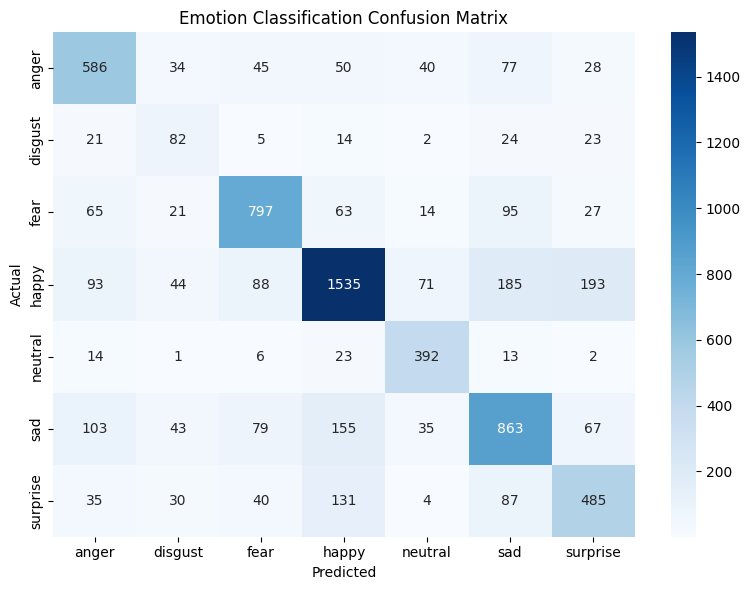


🎯 Overall Accuracy: 68.40%

📈 Average Confidence per Predicted Emotion

pred_label
anger       0.728219
disgust     0.650444
fear        0.749743
happy       0.716753
neutral     0.779222
sad         0.687304
surprise    0.652895
Name: confidence, dtype: float32

❌ Sample Misclassified Examples

Text: Yes . My bike has one under the seat . Get it , quick !
True: fear
Pred: happy
Confidence: 0.528
------------------------------------------------------------
Text: Fashion show all after noon
True: happy
Pred: surprise
Confidence: 0.466
------------------------------------------------------------
Text: Volleyball season is over, correction high school volleyball is over &lt;/3
True: sad
Pred: happy
Confidence: 0.807
------------------------------------------------------------
Text: J'attend avec impatience Noel , je connais aucun de mes cadeaux !
True: surprise
Pred: fear
Confidence: 0.708
------------------------------------------------------------
Text: I love seeing happily married co

In [5]:
# ==========================================
# 0. IMPORTS & GPU SAFETY
# ==========================================
import os
import numpy as np
import pandas as pd
import pickle
import tensorflow as tf
import tensorflow_hub as hub
import kagglehub

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

# Enable safe GPU memory growth (VERY IMPORTANT)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    print(f"✅ GPU detected: {gpus}")
else:
    print("⚠️ No GPU detected, running on CPU")

print("TensorFlow version:", tf.__version__)

# ==========================================
# 1. LOAD MODEL & LABEL ENCODER
# ==========================================
MODEL_PATH = "emotion_bert_model"
ENCODER_PATH = "label_encoder.pkl"

print("\n📦 Loading model...")
model = tf.keras.models.load_model(
    MODEL_PATH,
    custom_objects={"KerasLayer": hub.KerasLayer}
)

with open(ENCODER_PATH, "rb") as f:
    le = pickle.load(f)

print("✅ Model and LabelEncoder loaded")

# ==========================================
# 2. LOAD & PREPARE DATA (SAME AS TRAINING)
# ==========================================
print("\n📥 Loading dataset...")
path = kagglehub.dataset_download("mayurjare/emotion-datasets")
csv_file = [f for f in os.listdir(path) if f.endswith(".csv")][0]
df = pd.read_csv(os.path.join(path, csv_file))

label_map = {
    "joy": "happy",
    "sadness": "sad",
    "anger": "anger",
    "fear": "fear",
    "surprise": "surprise",
    "neutral": "neutral",
    "disgust": "disgust"
}

df = df[df["Emotion"].isin(label_map.keys())]
df["Emotion"] = df["Emotion"].map(label_map)
df["Clean_Text"] = df["Text"].astype(str).str.strip()

# Encode labels using SAVED LabelEncoder
y_all = le.transform(df["Emotion"])

# SAME split as training
X_train, X_test, y_train, y_test = train_test_split(
    df["Clean_Text"],
    y_all,
    test_size=0.2,
    random_state=42,
    stratify=y_all
)

print(f"Test samples: {len(X_test)}")

# ==========================================
# 3. GPU-SAFE BATCHED INFERENCE (FIXES OOM)
# ==========================================
print("\n🚀 Running batched inference (OOM-safe)...")

BATCH_SIZE = 16   # ⬅️ CRITICAL: prevents GPU OOM

y_probs = model.predict(
    np.array(X_test),
    batch_size=BATCH_SIZE,
    verbose=1
)

y_pred = np.argmax(y_probs, axis=1)

# ==========================================
# 4. CLASSIFICATION REPORT
# ==========================================
print("\n📊 CLASSIFICATION REPORT\n")
print(
    classification_report(
        y_test,
        y_pred,
        target_names=le.classes_,
        digits=4
    )
)

# ==========================================
# 5. CONFUSION MATRIX
# ==========================================
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=le.classes_,
    yticklabels=le.classes_
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Emotion Classification Confusion Matrix")
plt.tight_layout()
plt.show()

# ==========================================
# 6. OVERALL ACCURACY
# ==========================================
accuracy = np.mean(y_test == y_pred)
print(f"\n🎯 Overall Accuracy: {accuracy * 100:.2f}%")

# ==========================================
# 7. AVERAGE CONFIDENCE PER EMOTION
# ==========================================
confidence_df = pd.DataFrame({
    "true_label": le.inverse_transform(y_test),
    "pred_label": le.inverse_transform(y_pred),
    "confidence": y_probs.max(axis=1)
})

print("\n📈 Average Confidence per Predicted Emotion\n")
print(confidence_df.groupby("pred_label")["confidence"].mean())

# ==========================================
# 8. SAMPLE MISCLASSIFICATIONS
# ==========================================
errors = confidence_df[confidence_df["true_label"] != confidence_df["pred_label"]]

print("\n❌ Sample Misclassified Examples\n")

if len(errors) > 0:
    for i in errors.sample(min(5, len(errors)), random_state=42).index:
        print("Text:", X_test.iloc[i])
        print("True:", confidence_df.loc[i, "true_label"])
        print("Pred:", confidence_df.loc[i, "pred_label"])
        print("Confidence:", round(confidence_df.loc[i, "confidence"], 3))
        print("-" * 60)
else:
    print("No misclassifications found 🎉")
